In [3]:
import process as pc

pc.extract_dataset()
img_list = pc.load_images(number_of_images=500, random_seed=7)
images = []
for img in img_list:
    images.append(pc.process_image(pc.DATA_PATH+"/img_align_celeba/"+img))

CelebA dataset already extracted
['052576.jpg' '137883.jpg' '179329.jpg' '006858.jpg' '047431.jpg'
 '097468.jpg' '181681.jpg' '070326.jpg' '119807.jpg' '159029.jpg'
 '054842.jpg' '155277.jpg' '039119.jpg' '036520.jpg' '013005.jpg'
 '125792.jpg' '180526.jpg' '000517.jpg' '111909.jpg' '089475.jpg'
 '040242.jpg' '129282.jpg' '087565.jpg' '001021.jpg' '092126.jpg'
 '192029.jpg' '053212.jpg' '012563.jpg' '052371.jpg' '026587.jpg'
 '195861.jpg' '114304.jpg' '167178.jpg' '159727.jpg' '051182.jpg'
 '076644.jpg' '090547.jpg' '010792.jpg' '047618.jpg' '157396.jpg'
 '070792.jpg' '102406.jpg' '187855.jpg' '076482.jpg' '011852.jpg'
 '122851.jpg' '061446.jpg' '173864.jpg' '026891.jpg' '128128.jpg'
 '111683.jpg' '040846.jpg' '101814.jpg' '094453.jpg' '000307.jpg'
 '119034.jpg' '131156.jpg' '003750.jpg' '183086.jpg' '069341.jpg'
 '199720.jpg' '094756.jpg' '086333.jpg' '164772.jpg' '090164.jpg'
 '152508.jpg' '133410.jpg' '188516.jpg' '032726.jpg' '023615.jpg'
 '088994.jpg' '055338.jpg' '014853.jpg' '15

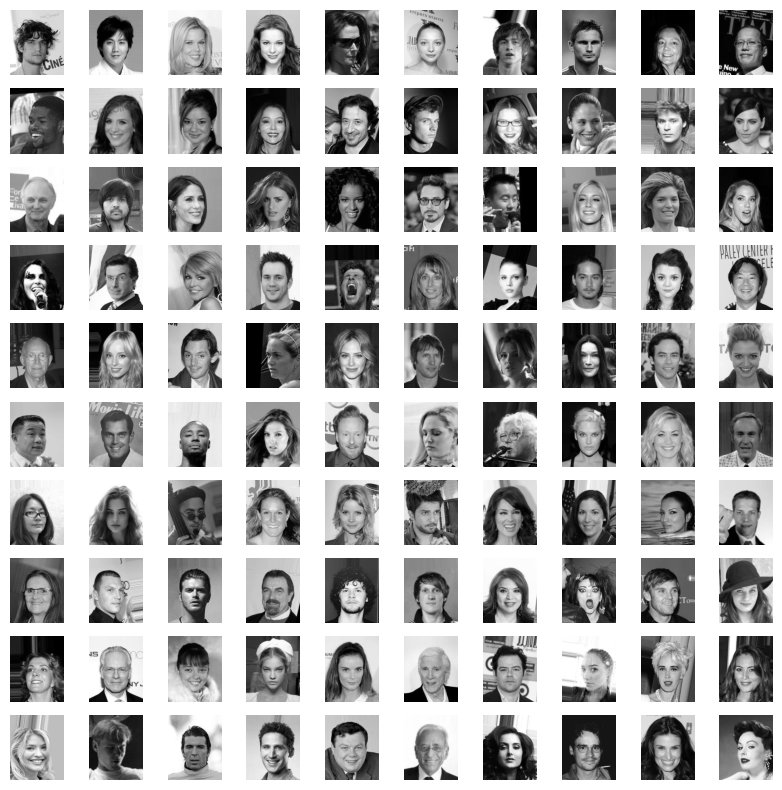

In [4]:
import matplotlib.pyplot as plt
import numpy as np
fig, ax = plt.subplots(10, 10, figsize=(10, 10))
for i in range(10):
    for j in range(10):
        ax[i, j].imshow(images[i*10+j], cmap='gray')
        ax[i, j].axis('off')